In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_paths import *

GRAPH_DATA_PATH = 'graph_data/'

In [28]:
df = pd.read_pickle(MERGED)
cosmic_proteins = pd.read_csv(COSMIC_PROTEINS, sep='\t')

In [29]:
cosmic_proteins.head(1)

,Gene,Gene synonym,Ensembl,Gene description,Uniprot,Chromosome,Position,Protein class,Biological process,Molecular function,...,Cancer prognostics - Pancreatic Adenocarcinoma (TCGA),Cancer prognostics - Pancreatic Adenocarcinoma (validation),Cancer prognostics - Prostate Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (validation),Cancer prognostics - Skin Cuteneous Melanoma (TCGA),Cancer prognostics - Stomach Adenocarcinoma (TCGA),Cancer prognostics - Testicular Germ Cell Tumor (TCGA),Cancer prognostics - Thyroid Carcinoma (TCGA),Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA)
0,ABI1,"ABI-1, E3B1, SSH3BP1",ENSG00000136754,Abl interactor 1,Q8IZP0,10,26746593-26861087,"Cancer-related genes, Disease related genes, P...",Host-virus interaction,NaN,...,unprognostic (6.17e-3),unprognostic (9.66e-2),unprognostic (8.60e-2),unprognostic (1.16e-1),unprognostic (3.28e-2),unprognostic (1.01e-1),unprognostic (3.66e-1),unprognostic (1.72e-1),unprognostic (1.03e-1),unprognostic (1.72e-1)


### Check if synonyms could be used

In [30]:
arr = cosmic_proteins['Gene synonym'].apply(lambda x: np.array([y.strip() for y in str(x).split(',')]))
all_elems = np.concatenate(arr)

# Check isin for each element in the array (careful of double lists)
df['target_name'].isin(all_elems).sum(), df['drugbank_protein_name'].isin(all_elems).sum()

(0, 0)

In [31]:
cosmic_proteins['Uniprot']

0      Q8IZP0
1      P00519
2      P42684
3      P25106
4      O95573
        ...  
567    Q9UBW7
568    Q9NQX6
569    Q8TF68
570    Q96K83
571    Q15696
Name: Uniprot, Length: 572, dtype: object

In [32]:
# Matching by drugbank_protein_name
nb_bind_in_cosmic_bn = df['drugbank_protein_name'].isin(cosmic_proteins['Gene']).sum()
nb_cosmic_in_bind_bn = cosmic_proteins['Gene'].isin(df['drugbank_protein_name']).sum()
nb_bind_in_cosmic_by_targetname_bn = df['target_name'].isin(cosmic_proteins['Gene']).sum()

# Matching by uniprot
nb_bind_in_cosmic_bu = df['swissprot_protein_id'].dropna().isin(cosmic_proteins['Uniprot']).sum()
nb_cosmic_in_bind_bu = cosmic_proteins['Uniprot'].isin(df['swissprot_protein_id'].dropna()).sum()

print(f"Number of bind proteins in cosmic by drugbank_protein_name: {nb_bind_in_cosmic_bn}")
print(f"Number of cosmic proteins in bind by drugbank_protein_name: {nb_cosmic_in_bind_bn}")
print()
print(f"Number of bind proteins in cosmic by target_name: {nb_bind_in_cosmic_by_targetname_bn}")
print()
print(f"Number of bind proteins in cosmic by uniprot: {nb_bind_in_cosmic_bu}")
print(f"Number of cosmic proteins in bind by uniprot: {nb_cosmic_in_bind_bu}")

Number of bind proteins in cosmic by drugbank_protein_name: 20199
Number of cosmic proteins in bind by drugbank_protein_name: 45

Number of bind proteins in cosmic by target_name: 0

Number of bind proteins in cosmic by uniprot: 32320
Number of cosmic proteins in bind by uniprot: 75


### Cancer related proteins

In [33]:
bind_cancer_proteins_by_name = df[df['drugbank_protein_name'].isin(cosmic_proteins['Gene'])]
bind_cancer_proteins_by_uniprot = df[df['swissprot_protein_id'].isin(cosmic_proteins['Uniprot'])]

bcpbn_set = set(bind_cancer_proteins_by_name['target_name'])
bcpbu_set = set(bind_cancer_proteins_by_uniprot['target_name'])

print(f"Number of cancer proteins in bind by drugbank_protein_name: {len(bcpbn_set)}")
print(f"Number of cancer proteins in bind by uniprot: {len(bcpbu_set)}")
print(f"Difference between the two sets:")
print(f"  - {len(bcpbn_set - bcpbu_set)} proteins in drugbank_protein_name but not in uniprot")
print(f"  - {len(bcpbu_set - bcpbn_set)} proteins in uniprot but not in drugbank_protein_name")

Number of cancer proteins in bind by drugbank_protein_name: 91
Number of cancer proteins in bind by uniprot: 142
Difference between the two sets:
  - 4 proteins in drugbank_protein_name but not in uniprot
  - 55 proteins in uniprot but not in drugbank_protein_name


In [34]:
cancer_proteins_namey_not_uniprot = df[df['target_name'].isin(bcpbn_set - bcpbu_set)]
cancer_proteins_namey_not_uniprot[['drugbank_protein_name', 'target_name', 'swissprot_protein_id']]

,drugbank_protein_name,target_name,swissprot_protein_id
64111,EGFR,"Phosphatidylinositol 4,5-bisphosphate 3-kinase...",Q504U8
64125,EGFR,Receptor protein-tyrosine kinase/Serine/threon...,Q504U8
64139,EGFR,DNA-dependent protein kinase catalytic subunit...,Q504U8
64153,EGFR,"Phosphatidylinositol 4,5-bisphosphate 3-kinase...",Q504U8


In [35]:
cosmic_proteins[cosmic_proteins['Gene'] == 'EGFR'][['Gene', 'Gene synonym', 'Uniprot']]

,Gene,Gene synonym,Uniprot
141,EGFR,"ERBB, ERBB1, ERRP",P00533


In [36]:
# Combine the two sets (even though Uniprot is not the same)
cancer_related_proteins = pd.concat([bind_cancer_proteins_by_name, bind_cancer_proteins_by_uniprot]).drop_duplicates()
cancer_related_proteins_df = df[df['target_name'].isin(cancer_related_proteins['target_name'])]

print(f"Number of pairs of cancer proteins with their ligand in bind: {len(cancer_related_proteins_df)}")
print(f"Number of unique cancer proteins: {len(cancer_related_proteins['target_name'].unique())}")
print(f"  - {len(bind_cancer_proteins_by_name['target_name'].unique())} by drugbank_protein_name")
print(f"  - {len(bind_cancer_proteins_by_uniprot['target_name'].unique())} by uniprot")

Number of pairs of cancer proteins with their ligand in bind: 67058
Number of unique cancer proteins: 146
  - 91 by drugbank_protein_name
  - 142 by uniprot


### Ligands related to these proteins

In [37]:
ligands_related_to_cancer_proteins = cancer_related_proteins_df.dropna(subset=['ligand_name'])

print(f"Number of pairs of ligands related to cancer proteins (keep only the ones for which we have a name): {len(ligands_related_to_cancer_proteins)}")
print(f"Number of unique ligands related to cancer proteins: {len(set(ligands_related_to_cancer_proteins['ligand_name']))}")
print(f"Number of cancer proteins that matched to a ligand: {len(set(ligands_related_to_cancer_proteins['target_name']))} out of {len(cancer_related_proteins['target_name'].unique())}")

Number of pairs of ligands related to cancer proteins (keep only the ones for which we have a name): 67058
Number of unique ligands related to cancer proteins: 39196
Number of cancer proteins that matched to a ligand: 146 out of 146


In [38]:
# Keep only the ligands that are in DrugBank 
drugs_related_to_cancer_proteins = ligands_related_to_cancer_proteins.dropna(subset='drugbank_drug_class_superclass')

print(f"Number of pairs of drugs related to cancer proteins: {len(drugs_related_to_cancer_proteins)}")
print(f"Number of unique drugs related to cancer proteins: {len(drugs_related_to_cancer_proteins['drugbank_drug_name'].unique())}")
print(f"Number of cancer proteins that matched to a drug: {len(set(drugs_related_to_cancer_proteins['target_name']))} out of {len(cancer_related_proteins['target_name'].unique())}")

Number of pairs of drugs related to cancer proteins: 3192
Number of unique drugs related to cancer proteins: 321
Number of cancer proteins that matched to a drug: 68 out of 146


### All proteins related to these ligands

In [39]:
all_prots_related_to_cancer_ligands = df[df['ligand_name'].isin(ligands_related_to_cancer_proteins['ligand_name'].unique())]
all_prots_related_to_cancer_drugs = df[df['drugbank_drug_name'].isin(drugs_related_to_cancer_proteins['drugbank_drug_name'].unique())]

print(f"Number of unique proteins related to cancer ligands: {len(all_prots_related_to_cancer_ligands['target_name'].unique())}")
print(f"Number of unique proteins related to cancer drugs: {len(all_prots_related_to_cancer_drugs['target_name'].unique())}")

Number of unique proteins related to cancer ligands: 2092
Number of unique proteins related to cancer drugs: 1592


### Differentiate between secondary effects and drugs

In [40]:
direct_prots_related_target_names = cancer_related_proteins['target_name'].unique()

direct_effect_prots = all_prots_related_to_cancer_drugs[all_prots_related_to_cancer_drugs['target_name'].isin(direct_prots_related_target_names)]
secondary_effect_prots = all_prots_related_to_cancer_drugs[~all_prots_related_to_cancer_drugs['target_name'].isin(direct_prots_related_target_names)]

ligands_direct_effect_prots = all_prots_related_to_cancer_ligands[all_prots_related_to_cancer_ligands['target_name'].isin(direct_prots_related_target_names)]
ligands_secondary_effect_prots = all_prots_related_to_cancer_ligands[~all_prots_related_to_cancer_ligands['target_name'].isin(direct_prots_related_target_names)]

print(f"Number of proteins directly targeted by drugs: {len(direct_effect_prots['target_name'].unique())}")
print(f"Number of proteins representing secondary effect of drugs: {len(secondary_effect_prots['target_name'].unique())}")
print()
print(f"Number of proteins directly targeted by ligands: {len(ligands_direct_effect_prots['target_name'].unique())}")
print(f"Number of proteins representing secondary effect of ligands: {len(ligands_secondary_effect_prots['target_name'].unique())}")

Number of proteins directly targeted by drugs: 68
Number of proteins representing secondary effect of drugs: 1524

Number of proteins directly targeted by ligands: 146
Number of proteins representing secondary effect of ligands: 1946


Note that cancer related proteins has 146 distinct prots, but as we keep only the ones that are linked to a ligand in bindingdb, we end up using only 66 (61 for drugs) out of those 146 prots. So in the end, the difference between number of proteins directly targeted by ligands and the number of proteins that are related to cancer is only because of this:
```	python
    ligands_related_to_cancer_proteins = cancer_related_proteins_df.dropna(subset=['drugbank_drug_name'])
```
In summary, 
- we have 146 cancer prots
- they link to 405 ligands (ligands related to cancer prots), which themselves only link to 66 of the cancer prots (61 for drugs)
- these 405 ligands link to all prots which around 1651 prots
- out of all these prots, as we've seen 66 are cancer related (61 for drugs), and 1504 are likely proteins on which the drug has secondary effects

The difference between the 146 cancer prots and the 66 cancer prots is really because only a subset of the cancer prots can be used for our analysis. And this subset, as explained above, is given by the dropna on drugbank_drug_name which is the name of the ligand.

## Graph of the relationships

In [41]:

# Create a list of nodes
nodes = []
node_id_map = {}  # To map node names to unique ids
categories = [{'name': 'Possible Cancer Drug'}, {'name': 'Cancer Protein'}]

# Process ligand nodes
ligand_nodes = all_prots_related_to_cancer_drugs['drugbank_drug_name'].dropna().unique()
for idx, ligand in enumerate(ligand_nodes):
    ligand = str(ligand)
    node_id_map[ligand] = idx
    node = {
        'id': str(idx),
        'Label': ligand,
        'category': 0,  # Index of 'ligand' in categories
        'value': 1  # You can set this to degree or other measure
    }
    nodes.append(node)

# Process protein nodes
cancer_protein_nodes = direct_effect_prots['target_name'].unique()
for idx, protein in enumerate(cancer_protein_nodes, start=len(node_id_map)):
    node_id_map[protein] = idx
    node = {
        'id': str(idx),
        'Label': protein,
        'category': 1,  # Index of 'protein' in categories
        'value': 1  # You can set this to degree or other measure
    }
    nodes.append(node)

# Create a list of edges
edges = []
for _, row in direct_effect_prots.iterrows():
    source_id = node_id_map[row['drugbank_drug_name']]
    target_id = node_id_map[row['target_name']]
    strength = row['ec50'] if pd.isna(row['ic50']) else row['ic50']  # Use ec50 if ic50 is NaN
    
    if pd.isna(strength) or strength < 1e-8 or np.log(strength) < 1e-8:
        continue

    strengths = np.log(np.log(strength))  # Log-transform the value to make it more visually appealing

    edge = {
        'source': str(source_id),
        'target': str(target_id),
        'sourceLabel': row['drugbank_drug_name'],
        'targetLabel': row['target_name'],
        'Weight': strengths  
    }
    edges.append(edge)

# Modify strength to be in the range [0, 1]
max_strength = max([edge['Weight'] for edge in edges])
min_strength = min([edge['Weight'] for edge in edges])

for i, edge in enumerate(edges):
    edges[i]['Weight'] = (edge['Weight'] - min_strength) / (max_strength - min_strength)
    edges[i]['Weight'] = np.clip(edges[i]['Weight'], 0.4, 1)
    edges[i]['Weight'] = (edges[i]['Weight'] - 0.4) / 0.6

# Create the graph data
graph_data = {
    'nodes': nodes,
    'links': edges,
    'categories': categories
}

(array([ 43.,  11.,  23.,  59.,  16.,  24.,  58.,  48.,  73., 133., 143.,
        214., 209., 223., 186., 188., 182.,  88.,  17.,   2.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

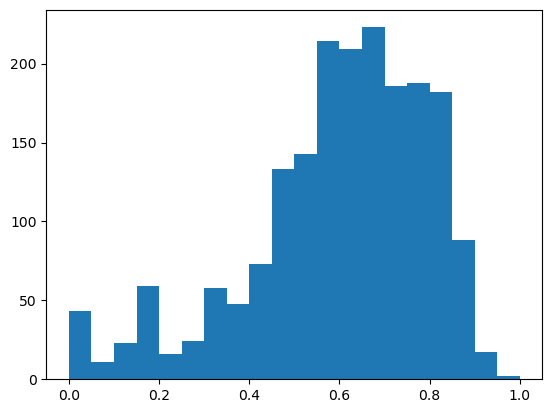

In [42]:
strengths = [edges['Weight'] for edges in graph_data['links']]
strengths
plt.hist(strengths, bins=20)

## Gephi visualization

In [43]:
import igraph as ig

# Extract node and edge data
nodes = graph_data['nodes']
edges = graph_data['links']
categories = graph_data['categories']

# Create an igraph graph
g = ig.Graph(directed=False)  # Set directed=True if your data is directional
g.add_vertices(len(nodes))

# Add vertex attributes
for i, node in enumerate(nodes):
    g.vs[i]['name'] = node['Label']
    g.vs[i]['category'] = categories[node['category']]['name']

# Add edges
edge_list = [(int(e['source']), int(e['target'])) for e in edges]
g.add_edges(edge_list)

# Add edge attributes
if 'Weight' in edges[0]:
    for i, e in enumerate(edges):
        g.es[i]['affinity'] = e['Weight']
        g.es[i]['sourceLabel'] = e['sourceLabel']
        g.es[i]['targetLabel'] = e['targetLabel']

for v in g.vs:
    # If this vertex's category is that of a ligand, set type=True
    v['type'] = (v['category'] == 'Possible Cancer Drug')



In [44]:
g_ligand_proj, g_protein_proj = g.bipartite_projection(multiplicity=True)

In [45]:
# Export ligand projection and protein projections to nodes and edges csv
ligand_nodes = []
ligand_edges = []
for i, v in enumerate(g_ligand_proj.vs):
    ligand_nodes.append({
        'id': i,
        'Label': v['name'],
        'category': 0,  # Index of 'ligand' in categories
    })

for e in g_ligand_proj.es:
    ligand_edges.append({
        'source': e.source,
        'target': e.target,
        'Weight': e['weight']
    })

protein_nodes = []
protein_edges = []
for i, v in enumerate(g_protein_proj.vs):
    protein_nodes.append({
        'id': i,
        'Label': v['name'],
        'category': 1,  # Index of 'protein' in categories
    })

for e in g_protein_proj.es:
    protein_edges.append({
        'source': e.source,
        'target': e.target,
        'Weight': e['weight']
    })

bipartite_nodes = []
bipartite_edges = []

for i, v in enumerate(g.vs):
    bipartite_nodes.append({
        'id': i,
        'Label': v['name'],
        'category': v['category'],
        'type': v['type']
    })

for e in g.es:
    bipartite_edges.append({
        'source': e.source,
        'target': e.target,
        'Weight': e['affinity']
    })



In [46]:
ligand_nodes_df = pd.DataFrame(ligand_nodes)
ligand_edges_df = pd.DataFrame(ligand_edges)

protein_nodes_df = pd.DataFrame(protein_nodes)
protein_edges_df = pd.DataFrame(protein_edges)

bipartite_nodes_df = pd.DataFrame(bipartite_nodes)
bipartite_edges_df = pd.DataFrame(bipartite_edges)

ligand_nodes_df.to_csv(GRAPH_DATA_PATH + 'ligand_nodes.csv', index=False)
ligand_edges_df.to_csv(GRAPH_DATA_PATH + 'ligand_edges.csv', index=False)

protein_nodes_df.to_csv(GRAPH_DATA_PATH + 'protein_nodes.csv', index=False)
protein_edges_df.to_csv(GRAPH_DATA_PATH + 'protein_edges.csv', index=False)

bipartite_nodes_df.to_csv(GRAPH_DATA_PATH + 'bipartite_nodes.csv', index=False)
bipartite_edges_df.to_csv(GRAPH_DATA_PATH + 'bipartite_edges.csv', index=False)

## Gephi

In [47]:
def get_target_name_nonmutant(x):
    return x.split('[')[0]
df['target_name_nonmutant'] = df['target_name'].apply(get_target_name_nonmutant)

df['target_name'].nunique(), df['target_name_nonmutant'].nunique()

(6741, 5814)

In [48]:
unique_prots = df['target_name_nonmutant'].unique()

protein_to_doi = {prot: set() for prot in unique_prots}
for _, row in df.iterrows():
    protein = row['target_name_nonmutant']
    doi = row['doi']
    protein_to_doi[protein].add(doi)

count = {prot: len(dois) for prot, dois in protein_to_doi.items()}

In [49]:
# Map target names to their respective counts
target_name_to_count = {row['target_name']: count[row['target_name_nonmutant']] for _, row in df.iterrows()}

In [50]:

# Create a list of nodes
nodes = []
node_id_map = {}  # To map node names to unique ids
categories = [{'name': 'Possible Cancer Drug'}, {'name': 'Cancer Protein'}]

# Process ligand nodes
ligand_nodes = all_prots_related_to_cancer_drugs['drugbank_drug_name'].dropna().unique()
for idx, ligand in enumerate(ligand_nodes):
    ligand = str(ligand)
    node_id_map[ligand] = idx
    node = {
        'id': str(idx),
        'Label': ligand,
        'category': 0,  # Index of 'ligand' in categories
    }
    nodes.append(node)

# Process protein nodes
cancer_protein_nodes = direct_effect_prots['target_name'].unique()

# Start from the length of the ligand nodes (to avoid overlapping ids)
for idx, protein in enumerate(cancer_protein_nodes, start=len(node_id_map)):
    node_id_map[protein] = idx
    node = {
        'id': str(len(ligand_nodes) + idx),
        'Label': protein,
        'category': 1,  # Index of 'protein' in categories
    }
    nodes.append(node)

# Create a list of edges
edges = []
for _, row in direct_effect_prots.iterrows():
    source_id = node_id_map[row['drugbank_drug_name']]
    target_id = node_id_map[row['target_name']]
    strength = row['ec50'] if pd.isna(row['ic50']) else row['ic50']  # Use ec50 if ic50 is NaN
    
    if pd.isna(strength) or strength < 1e-8 or np.log(strength) < 1e-8:
        continue

    strengths = np.log(np.log(strength))  # Log-transform the value to make it more visually appealing

    edge = {
        'source': str(source_id),
        'target': str(target_id),
        'sourceLabel': row['drugbank_drug_name'],
        'targetLabel': row['target_name'],
        'Weight': strengths  
    }
    edges.append(edge)

# Modify strength to be in the range [0, 1]
max_strength = max([edge['Weight'] for edge in edges])
min_strength = min([edge['Weight'] for edge in edges])

for i, edge in enumerate(edges):
    edges[i]['Weight'] = (edge['Weight'] - min_strength) / (max_strength - min_strength)
    edges[i]['Weight'] = np.clip(edges[i]['Weight'], 0.4, 1)
    edges[i]['Weight'] = (edges[i]['Weight'] - 0.4) / 0.6

# Create the graph data
graph_data = {
    'nodes': nodes,
    'links': edges,
    'categories': categories
}

In [51]:
import igraph as ig

# Extract node and edge data
nodes = graph_data['nodes']
edges = graph_data['links']
categories = graph_data['categories']

# Create an igraph graph
g_cancer = ig.Graph(directed=False)  # Set directed=True if your data is directional
g_cancer.add_vertices(len(nodes))

# Add vertex attributes
for i, node in enumerate(nodes):
    g_cancer.vs[i]['name'] = node['Label']
    g_cancer.vs[i]['category'] = categories[node['category']]['name']

# Add edges
edge_list = [(int(e['source']), int(e['target'])) for e in edges]
g_cancer.add_edges(edge_list)

# Add edge attributes
if 'Weight' in edges[0]:
    for i, e in enumerate(edges):
        g_cancer.es[i]['affinity'] = e['Weight']
        g_cancer.es[i]['sourceLabel'] = e['sourceLabel']
        g_cancer.es[i]['targetLabel'] = e['targetLabel']

for v in g_cancer.vs:
    # If this vertex's category is that of a ligand, set type=True
    v['type'] = (v['category'] == 'Possible Cancer Drug')



In [52]:

# Create a list of nodes
nodes = []
node_id_map = {}  # To map node names to unique ids
categories = [{'name': 'Ligand'}, {'name': 'Protein'}]

# Process ligand nodes
ligand_nodes = df['ligand_name'].dropna().unique()
for idx, ligand in enumerate(ligand_nodes):
    ligand = str(ligand)
    node_id_map[ligand] = idx
    node = {
        'id': str(idx),
        'Label': ligand,
        'category': 0,  # Index of 'ligand' in categories
        'research_count': np.median(list(target_name_to_count.values()))
    }
    nodes.append(node)

# Process protein nodes
protein_nodes = df['target_name'].dropna().unique()
for idx, protein in enumerate(protein_nodes, start=len(node_id_map)):
    node_id_map[protein] = idx
    node = {
        'id': str(idx),
        'Label': protein,
        'category': 1,  # Index of 'protein' in categories
        'research_count': target_name_to_count[protein]
    }
    nodes.append(node)

# Process edges efficiently
weights_ic = df['ic50'].values
weights_ec = df['ec50'].values
weights = np.where(pd.isna(weights_ic), weights_ec, weights_ic)

weights = np.log(np.log(weights))
max_strength = np.quantile(weights[~np.isnan(weights)], 0.95)
min_strength = np.quantile(weights[~np.isnan(weights)], 0.05)
weights = (weights - min_strength) / (max_strength - min_strength)
weights = np.where(np.isnan(weights), 0, weights)
weights = np.where(weights < 0.1, pd.NA, weights)

# Edges is df[['ligand_name', 'traget_name', weights]] where weights is not nan
# Don't use loop
edges = df[['ligand_name', 'target_name']].copy()
edges['source'] = edges['ligand_name'].map(node_id_map)
edges['target'] = edges['target_name'].map(node_id_map)
edges['sourceLabel'] = edges['ligand_name']
edges['targetLabel'] = edges['target_name']
edges['Weight'] = weights
edges = edges.dropna(subset=['source', 'target', 'Weight'])
edges['Weight'] = edges['Weight'].clip(0.1, 1)

edges = edges.to_dict(orient='records')

# Create the graph data
graph_data = {
    'nodes': nodes,
    'links': edges,
    'categories': categories
}

C:\Users\sebge\AppData\Local\Temp\ipykernel_12248\22594669.py:36: RuntimeWarning: divide by zero encountered in log
  weights = np.log(np.log(weights))
C:\Users\sebge\AppData\Local\Temp\ipykernel_12248\22594669.py:36: RuntimeWarning: invalid value encountered in log
  weights = np.log(np.log(weights))


In [53]:
# Extract node and edge data
nodes = graph_data['nodes']
edges = graph_data['links']
categories = graph_data['categories']

# Create an igraph graph
g = ig.Graph(directed=False)  # Set directed=True if your data is directional
g.add_vertices(len(nodes))

# Add vertex attributes
for i, node in enumerate(nodes):
    g.vs[i]['name'] = node['Label']
    g.vs[i]['category'] = categories[node['category']]['name']
    g.vs[i]['research_count'] = node['research_count']
    g.vs[i]['type'] = (node['category'] == 'Ligand')

# Add edges
edge_list = [(int(e['source']), int(e['target'])) for e in edges]
g.add_edges(edge_list)

# # Add edge attributes
if 'Weight' in edges[0]:
    for i, e in enumerate(edges):
        g.es[i]['affinity'] = e['Weight']
        g.es[i]['sourceLabel'] = e['sourceLabel']
        g.es[i]['targetLabel'] = e['targetLabel']


# # g = g.subgraph_edges(g.es.select(affinity_gt=0), delete_vertices=True)

# # Recompute nodes and edges
nodes = []
edges = []

for i, v in enumerate(g.vs):
    nodes.append({
        'id': i,
        'Label': v['name'],
        'category': v['category'],
        'type': v['type'],
        'research_count': v['research_count']
    })

for e in g.es:
    edges.append({
        'source': e.source,
        'target': e.target,
        'Weight': e['affinity'],
        'sourceLabel': e['sourceLabel'],
        'targetLabel': e['targetLabel']
    })


In [54]:
# Print affinities
len(edges)

1988879

In [55]:
all_nodes_df = pd.DataFrame(nodes)
all_edges_df = pd.DataFrame(edges)

all_nodes_df.to_csv(GRAPH_DATA_PATH + 'all_nodes.csv', index=False)
all_edges_df.to_csv(GRAPH_DATA_PATH + 'all_edges.csv', index=False)

## HTML Graphs

In [56]:
def bipartite_projection_with_affinity(g, project_on="ligand"):
    """
    Compute a bipartite projection of the given graph `g` onto either the ligand or protein side.
    Then, aggregate 'affinity' values for each projected edge.

    Parameters:
    g : igraph.Graph
        The original bipartite graph with
        - `g.es['affinity']` set on the bipartite edges
    project_on : str, optional, default: 'ligand'
        Which set of nodes to project on. 
        'ligand' projects onto ligand nodes (type=True),
        'protein' projects onto protein nodes (type=False).

    Returns:
    proj_nodes : list of dict
        A list of node dictionaries with 'id' and 'name'.
    proj_edges : list of dict
        A list of edge dictionaries with 'source', 'target', and aggregated 'affinity'.
    """

    # Perform bipartite projection
    # g_ligand_proj: projection onto ligand nodes
    # g_protein_proj: projection onto protein nodes
    g_ligand_proj, g_protein_proj = g.bipartite_projection(multiplicity=True)

    # Choose which projection to work with
    if project_on == "ligand":
        g_proj = g_ligand_proj
    elif project_on == "protein":
        g_proj = g_protein_proj
    else:
        raise ValueError("project_on must be either 'ligand' or 'protein'")

    # Create lookup from node name to original index for convenience
    name_to_index = {v['name']: v.index for v in g.vs}

    # Compute aggregated affinity on projected edges
    for e in g_proj.es:
        source_name = g_proj.vs[e.source]['name']
        target_name = g_proj.vs[e.target]['name']

        # Map back to original graph indices
        source_index = name_to_index[source_name]
        target_index = name_to_index[target_name]

        # Find common neighbors in original graph
        source_neighbors = set(g.neighbors(source_index))
        target_neighbors = set(g.neighbors(target_index))
        shared_intermediates = source_neighbors & target_neighbors

        # We do the average of the affinities
        affinities = []
        for p in shared_intermediates:
            eid_source_p = g.get_eid(source_index, p)
            eid_target_p = g.get_eid(target_index, p)

            aff_source_p = g.es[eid_source_p]['affinity']
            aff_target_p = g.es[eid_target_p]['affinity']

            avg_aff = (aff_source_p + aff_target_p) / 2.0
            affinities.append(avg_aff)

        e['affinity'] = sum(affinities)/len(affinities) if affinities else None

    # Retrieve nodes with their names
    proj_nodes = []
    for v in g_proj.vs:
        proj_nodes.append({
            'id': v.index,
            'name': v['name']
        })

    # Retrieve edges with their aggregated affinity
    proj_edges = []
    for e in g_proj.es:
        proj_edges.append({
            'source': e.source,
            'target': e.target,
            'affinity': e['affinity']
        })

    return proj_nodes, proj_edges


## Echarts Projected Graph

In [57]:
from pyecharts.charts import Graph
from pyecharts import options as opts

def generate_echarts_graph(nodes, edges):
    """
    Generate an ECharts graph from the given nodes and edges.

    Parameters:
    nodes : list of dict
        A list of node dictionaries with 'id', 'name', and 'symbolSize'.
    edges : list of dict
        A list of edge dictionaries with 'source', 'target', and 'lineStyle'.

    Returns:
    graph : pyecharts.charts.Graph
    """

    # Compute node degrees
    node_degrees = {node["id"]: 0 for node in nodes}
    for edge in edges:
        node_degrees[edge["source"]] += 1
        node_degrees[edge["target"]] += 1

    # Assign symbol_size to each node based on its degree
    for node in nodes:
        degree = node_degrees[node["id"]]
        # For example, make the size proportional to degree * 5, fallback to 10 if degree = 0
        node["symbolSize"] = np.clip(degree, 0.1, 10) if degree > 0 else 0.1

    # Assign edge width based on 'affinity' (if available)
    for edge in edges:
        weight = edge.get("affinity", 0.5) * 3
        edge["lineStyle"] = {"width": weight}  # scale it up if needed

    # Create the graph
    graph = Graph(init_opts=opts.InitOpts(width="100%", height="700px"))
    graph.add(
        series_name="",
        nodes=nodes,
        links=edges,
        layout="force",
        edge_length=[100, 250],
        repulsion=200,
        linestyle_opts=opts.LineStyleOpts(opacity=0.5)  # Base line style

    )

    graph.set_series_opts(
        label_opts=opts.LabelOpts(
            is_show=False,  # Hide labels by default
            position="right",
            formatter="{b}"  # Use node name as the label
        )
    )

    return graph


In [58]:
ligands_proj_nodes, ligands_proj_edges = bipartite_projection_with_affinity(g_cancer, project_on="ligand")
graph = generate_echarts_graph(ligands_proj_nodes, ligands_proj_edges)
graph.set_global_opts(
    title_opts=opts.TitleOpts(title="Cancer Drugs Projected Interaction Network")
)

graph.render("graph_data/cancer_ligands_graph.html")


'c:\\Users\\sebge\\source\\test2\\ada-2024-project-hyperbabbage\\graph_data\\cancer_ligands_graph.html'

In [60]:
proteins_proj_nodes, proteins_proj_edges = bipartite_projection_with_affinity(g_cancer, project_on="protein")
graph = generate_echarts_graph(proteins_proj_nodes, proteins_proj_edges)
graph.set_global_opts(
    title_opts=opts.TitleOpts(title="Cancer Proteins Projected Interaction Network")
)

graph.render("graph_data/cancer_proteins_graph.html")


'c:\\Users\\sebge\\source\\test2\\ada-2024-project-hyperbabbage\\graph_data\\cancer_proteins_graph.html'